<a href="https://colab.research.google.com/github/janghwan0113/graduation-thesis/blob/main/bacteria_classification_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, Concatenate, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import add, maximum, minimum, multiply, subtract, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(r'/content/drive/MyDrive/21-2/thesis/211020_dataset/train_labels.csv', index_col=0)
train_df['amplitude_file'] = train_df.index.map(lambda id : f'/content/drive/MyDrive/21-2/thesis/211020_dataset/train/{id}_a.jpg')
train_df['phase_file'] = train_df.index.map(lambda id : f'/content/drive/MyDrive/21-2/thesis/211020_dataset/train/{id}_p.jpg')

print(train_df.head())
print(train_df.amplitude_file.values)
print(train_df.phase_file.values)
print(train_df.bacteria.values)
print(len(train_df.bacteria.values))


        bacteria  ...                                         phase_file
id                ...                                                   
900000         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...
900001         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...
900002         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...
900003         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...
900004         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...

[5 rows x 3 columns]
['/content/drive/MyDrive/21-2/thesis/211020_dataset/train/900000_a.jpg'
 '/content/drive/MyDrive/21-2/thesis/211020_dataset/train/900001_a.jpg'
 '/content/drive/MyDrive/21-2/thesis/211020_dataset/train/900002_a.jpg'
 ...
 '/content/drive/MyDrive/21-2/thesis/211020_dataset/train/904497_a.jpg'
 '/content/drive/MyDrive/21-2/thesis/211020_dataset/train/904498_a.jpg'
 '/content/drive/MyDrive/21-2/thesis/211020_dataset/train/904499_a.jpg']
['/content/drive/MyDrive/21-2

In [ ]:
as_gray = True

if as_gray:
  in_channel = 1

img_rows, img_cols = 32, 32
num_classes = 5 # number of bacteria

batch_size = 32
epochs = 200
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

In [ ]:
def read_images(file_paths, img_rows, img_cols, as_gray, channels):

  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path, as_gray = as_gray))
  
  images = np.asarray(images, dtype=np.float32)
  
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [ ]:
# amplitude files
x_train_amplitude = read_images(train_df.amplitude_file.values, img_rows, img_cols, as_gray, in_channel)

# phase files
x_train_phase = read_images(train_df.phase_file.values, img_rows, img_cols, as_gray, in_channel)

# labels - convert class vectors to binary class matrices One Hot Encoding
labels = train_df.bacteria.values
labels = to_categorical(labels, num_classes)

In [ ]:
bacterias = ['BC', 'BR', 'MI', 'SA', 'SE']

# pick a random index from the list

temp_num = np.arange(0,train_df.bacteria.values.size,1)
rn_bacteria = np.random.choice(temp_num)
rn_label = train_df.bacteria.values[rn_bacteria]
rn_amplitude = x_train_amplitude[rn_bacteria]
rn_phase = x_train_phase[rn_bacteria]

#print(rn_bacteria)
#print(rn_label)
#print(rn_amplitude)
#print(rn_phase)

In [ ]:
plt.figure()
plt.axis('off')

plt.suptitle(f"{bacterias[rn_label]} (Label: {rn_label})", fontsize="x-large")

plt.subplot(121)
curr_img = None
if as_gray:
  curr_img = np.reshape(rn_amplitude, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_amplitude, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("Amplitude")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
if as_gray:
  curr_img = np.reshape(rn_phase, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_phase, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("Phase")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# stack so we can split on the same pair of images
x_train_comp = np.stack((x_train_amplitude, x_train_phase), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.25, random_state=666)

# take them apart
x_train_amplitude = x_train[:,:,:,:,0]
x_test_amplitude = x_test[:,:,:,:,0]

x_train_phase = x_train[:,:,:,:,1]
x_test_phase = x_test[:,:,:,:,1]

In [ ]:
# data agumentation
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                  input_shape=(32, 
                                                              32,
                                                              1)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    #layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)  
  ]
)

In [ ]:
def create_convolution_layers(input_img):
    data_augmentation,
    model = Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=input_shape)(input_img)
    model = MaxPooling2D((2, 2))(model)
#     model = Dropout(0.25)(model)

    model = Conv2D(64, (3, 3), padding='valid', activation='relu')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
#     model = Dropout(0.25)(model)

    model = Conv2D(128, (3, 3), padding='valid', activation='relu')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
#     model = Dropout(0.25)(model)

#     model = Conv2D(256, (3, 3), padding='same', activation='relu')(model)
#     model = AveragePooling2D(pool_size=(2, 2),padding='same')(model)
#     model = Dropout(0.25)(model)

    return model

In [ ]:
amplitude_input = Input(shape=input_shape)
amplitude_model = create_convolution_layers(amplitude_input)

phase_input = Input(shape=input_shape)
phase_model = create_convolution_layers(phase_input)


In [ ]:
conv = concatenate([amplitude_model, phase_model])
conv = Flatten()(conv)
dense = Dense(512, activation='relu')(conv)
dense = Dropout(0.5)(dense)
dense = Dense(256, activation='relu')(dense)
dense = Dropout(0.5)(dense)
output = Dense(num_classes, activation='softmax')(dense)

# example model summary

In [ ]:
# plot_model(model)
model = Model(inputs=[amplitude_input, phase_input], outputs=[output])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 30, 30, 32)   320         ['input_3[0][0]']                
                                                                                              

# SGD model

Epoch 1/200
106/106 [==============================] - 10s 86ms/step - loss: 2.7666 - accuracy: 0.1979 - val_loss: 1.6138 - val_accuracy: 0.1956
Epoch 2/200
106/106 [==============================] - 9s 85ms/step - loss: 1.6145 - accuracy: 0.2039 - val_loss: 1.6104 - val_accuracy: 0.1991
Epoch 3/200
106/106 [==============================] - 9s 85ms/step - loss: 1.6121 - accuracy: 0.2050 - val_loss: 1.6088 - val_accuracy: 0.2053
Epoch 4/200
106/106 [==============================] - 9s 84ms/step - loss: 1.6083 - accuracy: 0.2142 - val_loss: 1.6076 - val_accuracy: 0.2116
Epoch 5/200
106/106 [==============================] - 9s 85ms/step - loss: 1.6059 - accuracy: 0.2187 - val_loss: 1.6048 - val_accuracy: 0.2204
Epoch 6/200
106/106 [==============================] - 9s 84ms/step - loss: 1.6067 - accuracy: 0.2290 - val_loss: 1.6046 - val_accuracy: 0.2169
Epoch 7/200
106/106 [==============================] - 9s 84ms/step - loss: 1.5934 - accuracy: 0.2287 - val_loss: 1.5921 - val_accuracy

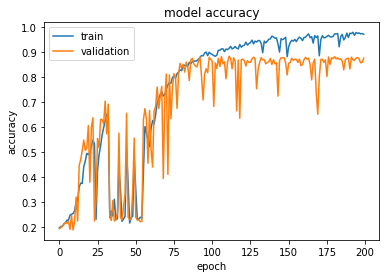

Maximum Train Accuracy : 0.9783703684806824
Maximum Validation Accuracy : 0.8826666474342346


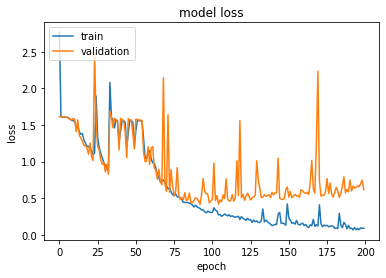

Minimum Train Loss : 0.06667400896549225
Minimum Validation Loss : 0.4161893129348755


In [ ]:
Bacteria_multi_model_SGD_001 = Model(inputs=[amplitude_input, phase_input], outputs=[output])
Bacteria_multi_model_SGD_001.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_SGD_001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)



# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(history.history['accuracy'])}")
print(f"Maximum Validation Accuracy : {max(history.history['val_accuracy'])}")


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(history.history['loss'])}")
print(f"Minimum Validation Loss : {min(history.history['val_loss'])}")

Epoch 1/200
106/106 [==============================] - 10s 89ms/step - loss: 2.4680 - accuracy: 0.2104 - val_loss: 1.5457 - val_accuracy: 0.2978
Epoch 2/200
106/106 [==============================] - 9s 86ms/step - loss: 1.5920 - accuracy: 0.2664 - val_loss: 1.4746 - val_accuracy: 0.3902
Epoch 3/200
106/106 [==============================] - 9s 87ms/step - loss: 1.5534 - accuracy: 0.2833 - val_loss: 1.4436 - val_accuracy: 0.4329
Epoch 4/200
106/106 [==============================] - 9s 88ms/step - loss: 1.4941 - accuracy: 0.3170 - val_loss: 1.4039 - val_accuracy: 0.4613
Epoch 5/200
106/106 [==============================] - 9s 87ms/step - loss: 1.4417 - accuracy: 0.3452 - val_loss: 1.3684 - val_accuracy: 0.4018
Epoch 6/200
106/106 [==============================] - 9s 87ms/step - loss: 1.3928 - accuracy: 0.3692 - val_loss: 1.2658 - val_accuracy: 0.4987
Epoch 7/200
106/106 [==============================] - 9s 88ms/step - loss: 1.3688 - accuracy: 0.3935 - val_loss: 1.2884 - val_accuracy

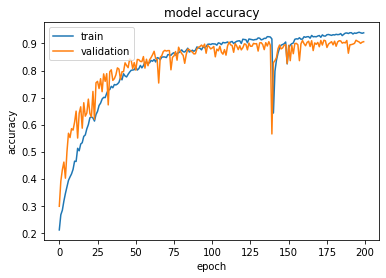

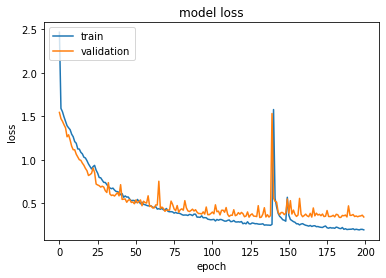

In [ ]:
Bacteria_multi_model_SGD_0001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
# Bacteria_multi_model_SGD_0001 = Model(inputs=[amplitude_input, phase_input], outputs=[output])
Bacteria_multi_model_SGD_0001.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights_SGD_0001.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_SGD_0001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/200
106/106 [==============================] - 10s 91ms/step - loss: 4.6250 - accuracy: 0.2279 - val_loss: 1.5540 - val_accuracy: 0.2018
Epoch 2/200
106/106 [==============================] - 9s 89ms/step - loss: 2.0256 - accuracy: 0.2447 - val_loss: 1.4811 - val_accuracy: 0.2942
Epoch 3/200
106/106 [==============================] - 9s 88ms/step - loss: 1.7446 - accuracy: 0.2640 - val_loss: 1.4389 - val_accuracy: 0.3369
Epoch 4/200
106/106 [==============================] - 9s 88ms/step - loss: 1.6601 - accuracy: 0.2759 - val_loss: 1.4188 - val_accuracy: 0.4071
Epoch 5/200
106/106 [==============================] - 9s 88ms/step - loss: 1.6086 - accuracy: 0.2913 - val_loss: 1.4130 - val_accuracy: 0.4587
Epoch 6/200
106/106 [==============================] - 9s 88ms/step - loss: 1.5552 - accuracy: 0.3064 - val_loss: 1.4004 - val_accuracy: 0.4996
Epoch 7/200
106/106 [==============================] - 9s 89ms/step - loss: 1.5425 - accuracy: 0.3093 - val_loss: 1.3801 - val_accuracy

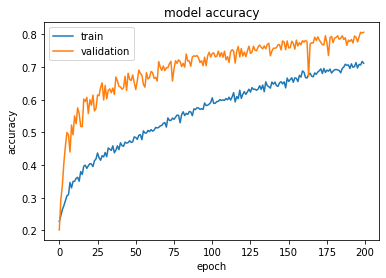

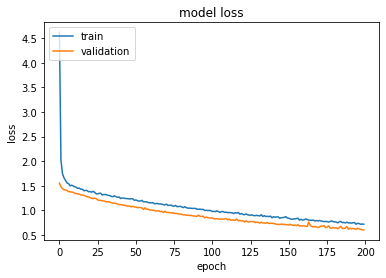

In [ ]:
Bacteria_multi_model_SGD_00001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_SGD_00001.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_SGD_00001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Adagrad model

Epoch 1/200
106/106 [==============================] - 10s 89ms/step - loss: 2.8398 - accuracy: 0.2936 - val_loss: 1.4203 - val_accuracy: 0.4524
Epoch 2/200
106/106 [==============================] - 9s 86ms/step - loss: 1.2840 - accuracy: 0.4400 - val_loss: 1.7665 - val_accuracy: 0.3111
Epoch 3/200
106/106 [==============================] - 9s 87ms/step - loss: 1.0709 - accuracy: 0.5603 - val_loss: 0.9698 - val_accuracy: 0.6480
Epoch 4/200
106/106 [==============================] - 9s 88ms/step - loss: 0.8472 - accuracy: 0.6601 - val_loss: 0.6624 - val_accuracy: 0.7547
Epoch 5/200
106/106 [==============================] - 9s 88ms/step - loss: 0.7225 - accuracy: 0.7129 - val_loss: 0.6745 - val_accuracy: 0.7582
Epoch 6/200
106/106 [==============================] - 9s 88ms/step - loss: 0.5824 - accuracy: 0.7828 - val_loss: 0.8093 - val_accuracy: 0.7120
Epoch 7/200
106/106 [==============================] - 9s 87ms/step - loss: 0.5191 - accuracy: 0.8071 - val_loss: 0.4475 - val_accuracy

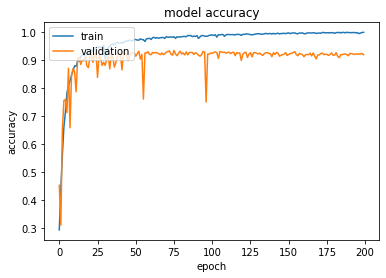

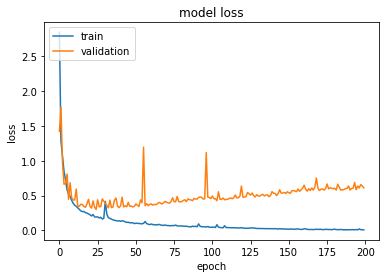

In [ ]:
Bacteria_multi_model_Adagrad_001 =tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adagrad_001.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adagrad_001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/200
106/106 [==============================] - 10s 92ms/step - loss: 2.7710 - accuracy: 0.2489 - val_loss: 1.4638 - val_accuracy: 0.3182
Epoch 2/200
106/106 [==============================] - 9s 86ms/step - loss: 1.5107 - accuracy: 0.3194 - val_loss: 1.3576 - val_accuracy: 0.4142
Epoch 3/200
106/106 [==============================] - 9s 85ms/step - loss: 1.4084 - accuracy: 0.3757 - val_loss: 1.2483 - val_accuracy: 0.4800
Epoch 4/200
106/106 [==============================] - 9s 85ms/step - loss: 1.3273 - accuracy: 0.4101 - val_loss: 1.1786 - val_accuracy: 0.5556
Epoch 5/200
106/106 [==============================] - 9s 86ms/step - loss: 1.2815 - accuracy: 0.4382 - val_loss: 1.1408 - val_accuracy: 0.5111
Epoch 6/200
106/106 [==============================] - 9s 86ms/step - loss: 1.2372 - accuracy: 0.4560 - val_loss: 1.0950 - val_accuracy: 0.6169
Epoch 7/200
106/106 [==============================] - 9s 86ms/step - loss: 1.1971 - accuracy: 0.4764 - val_loss: 1.0434 - val_accuracy

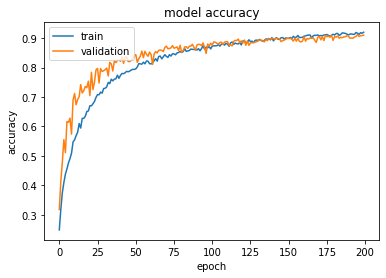

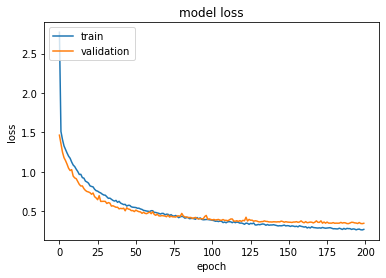

In [ ]:
Bacteria_multi_model_Adagrad_0001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adagrad_0001.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adagrad_0001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/200
106/106 [==============================] - 10s 89ms/step - loss: 7.7823 - accuracy: 0.1991 - val_loss: 1.7328 - val_accuracy: 0.2649
Epoch 2/200
106/106 [==============================] - 9s 88ms/step - loss: 4.4293 - accuracy: 0.2181 - val_loss: 1.5750 - val_accuracy: 0.2996
Epoch 3/200
106/106 [==============================] - 9s 88ms/step - loss: 3.4109 - accuracy: 0.2092 - val_loss: 1.5130 - val_accuracy: 0.2587
Epoch 4/200
106/106 [==============================] - 9s 88ms/step - loss: 2.7806 - accuracy: 0.2391 - val_loss: 1.5188 - val_accuracy: 0.2684
Epoch 5/200
106/106 [==============================] - 9s 88ms/step - loss: 2.5197 - accuracy: 0.2133 - val_loss: 1.5040 - val_accuracy: 0.2800
Epoch 6/200
106/106 [==============================] - 9s 88ms/step - loss: 2.2518 - accuracy: 0.2427 - val_loss: 1.4729 - val_accuracy: 0.3013
Epoch 7/200
106/106 [==============================] - 9s 88ms/step - loss: 2.1496 - accuracy: 0.2350 - val_loss: 1.4670 - val_accuracy

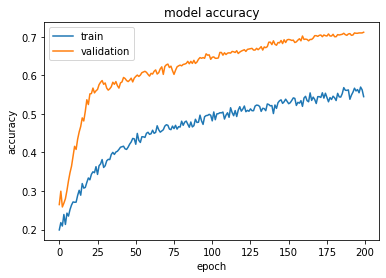

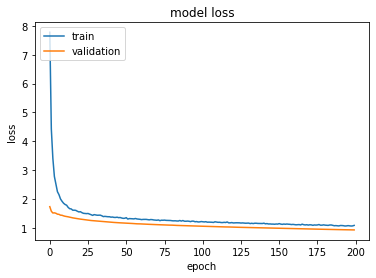

In [ ]:
Bacteria_multi_model_Adagrad_00001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adagrad_00001.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adagrad_00001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# RMSprop model

Epoch 1/200
106/106 [==============================] - 11s 92ms/step - loss: 168.3944 - accuracy: 0.2527 - val_loss: 1.4776 - val_accuracy: 0.2160
Epoch 2/200
106/106 [==============================] - 9s 89ms/step - loss: 3.3913 - accuracy: 0.2687 - val_loss: 1.5574 - val_accuracy: 0.2569
Epoch 3/200
106/106 [==============================] - 9s 89ms/step - loss: 6.9045 - accuracy: 0.2696 - val_loss: 1.6027 - val_accuracy: 0.2302
Epoch 4/200
106/106 [==============================] - 9s 89ms/step - loss: 3.9315 - accuracy: 0.2717 - val_loss: 1.5741 - val_accuracy: 0.2160
Epoch 5/200
106/106 [==============================] - 10s 91ms/step - loss: 2.2231 - accuracy: 0.2246 - val_loss: 1.5776 - val_accuracy: 0.2071
Epoch 6/200
106/106 [==============================] - 10s 90ms/step - loss: 1.9548 - accuracy: 0.2364 - val_loss: 1.5646 - val_accuracy: 0.2142
Epoch 7/200
106/106 [==============================] - 10s 90ms/step - loss: 2.4743 - accuracy: 0.2406 - val_loss: 1.5560 - val_acc

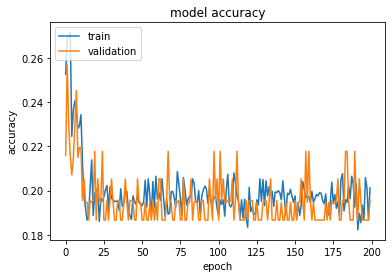

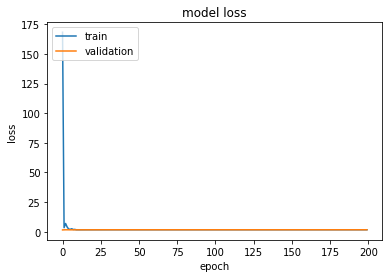

In [ ]:
Bacteria_multi_model_RMSprop_001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_RMSprop_001.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_RMSprop_001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



Epoch 1/200
106/106 [==============================] - 11s 92ms/step - loss: 2.8393 - accuracy: 0.2293 - val_loss: 1.6699 - val_accuracy: 0.2196
Epoch 2/200
106/106 [==============================] - 9s 90ms/step - loss: 1.6028 - accuracy: 0.3253 - val_loss: 1.5142 - val_accuracy: 0.2596
Epoch 3/200
106/106 [==============================] - 10s 90ms/step - loss: 1.1686 - accuracy: 0.5396 - val_loss: 0.9755 - val_accuracy: 0.6124
Epoch 4/200
106/106 [==============================] - 10s 90ms/step - loss: 0.8612 - accuracy: 0.6764 - val_loss: 0.7214 - val_accuracy: 0.7164
Epoch 5/200
106/106 [==============================] - 9s 89ms/step - loss: 0.7633 - accuracy: 0.7058 - val_loss: 0.5788 - val_accuracy: 0.8027
Epoch 6/200
106/106 [==============================] - 10s 90ms/step - loss: 0.6750 - accuracy: 0.7440 - val_loss: 0.5233 - val_accuracy: 0.8347
Epoch 7/200
106/106 [==============================] - 10s 90ms/step - loss: 0.5674 - accuracy: 0.7929 - val_loss: 0.8144 - val_accu

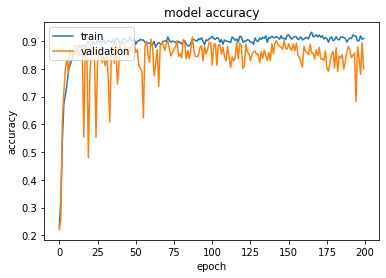

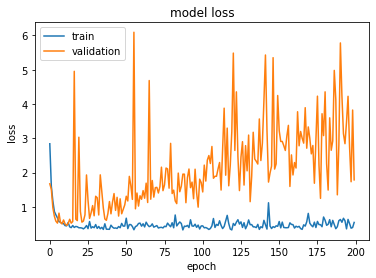

In [ ]:
Bacteria_multi_model_RMSprop_0001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_RMSprop_0001.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_RMSprop_0001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/200
106/106 [==============================] - 11s 93ms/step - loss: 2.9254 - accuracy: 0.2444 - val_loss: 1.4408 - val_accuracy: 0.3209
Epoch 2/200
106/106 [==============================] - 10s 91ms/step - loss: 1.5151 - accuracy: 0.3401 - val_loss: 1.2219 - val_accuracy: 0.4640
Epoch 3/200
106/106 [==============================] - 10s 92ms/step - loss: 1.3455 - accuracy: 0.4116 - val_loss: 1.1138 - val_accuracy: 0.6587
Epoch 4/200
106/106 [==============================] - 10s 92ms/step - loss: 1.1951 - accuracy: 0.4841 - val_loss: 1.2543 - val_accuracy: 0.4800
Epoch 5/200
106/106 [==============================] - 10s 92ms/step - loss: 1.0750 - accuracy: 0.5461 - val_loss: 0.8589 - val_accuracy: 0.6996
Epoch 6/200
106/106 [==============================] - 10s 92ms/step - loss: 0.9748 - accuracy: 0.5778 - val_loss: 0.7721 - val_accuracy: 0.7271
Epoch 7/200
106/106 [==============================] - 10s 92ms/step - loss: 0.8460 - accuracy: 0.6604 - val_loss: 0.7792 - val_ac

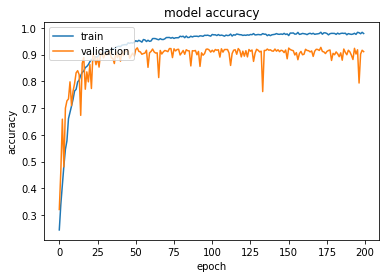

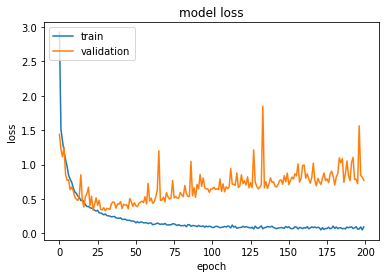

In [ ]:
Bacteria_multi_model_RMSprop_00001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_RMSprop_00001.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_RMSprop_00001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Adam model

Epoch 1/200
106/106 [==============================] - 10s 86ms/step - loss: 4.9984 - accuracy: 0.2199 - val_loss: 1.6114 - val_accuracy: 0.1867
Epoch 2/200
106/106 [==============================] - 9s 84ms/step - loss: 1.6131 - accuracy: 0.1923 - val_loss: 1.6085 - val_accuracy: 0.2178
Epoch 3/200
106/106 [==============================] - 9s 83ms/step - loss: 1.6108 - accuracy: 0.1970 - val_loss: 1.6135 - val_accuracy: 0.1867
Epoch 4/200
106/106 [==============================] - 9s 85ms/step - loss: 1.6112 - accuracy: 0.1979 - val_loss: 1.6101 - val_accuracy: 0.1956
Epoch 5/200
106/106 [==============================] - 9s 84ms/step - loss: 1.6111 - accuracy: 0.2033 - val_loss: 1.6116 - val_accuracy: 0.1867
Epoch 6/200
106/106 [==============================] - 9s 84ms/step - loss: 1.6109 - accuracy: 0.1991 - val_loss: 1.6105 - val_accuracy: 0.1956
Epoch 7/200
106/106 [==============================] - 9s 84ms/step - loss: 1.6106 - accuracy: 0.1950 - val_loss: 1.6104 - val_accuracy

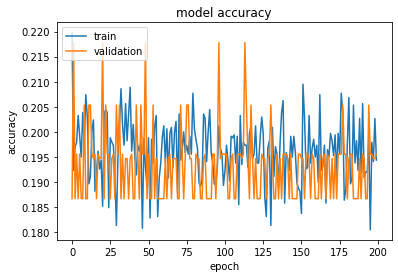

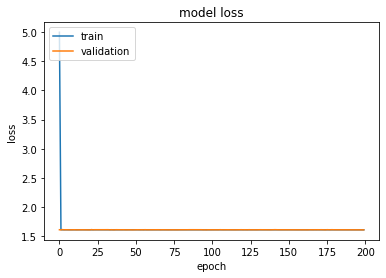

In [ ]:
Bacteria_multi_model_Adam_001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adam_001.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adam_001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



Epoch 1/200
106/106 [==============================] - 10s 86ms/step - loss: 2.0323 - accuracy: 0.3236 - val_loss: 1.1055 - val_accuracy: 0.5769
Epoch 2/200
106/106 [==============================] - 9s 85ms/step - loss: 1.0052 - accuracy: 0.5724 - val_loss: 0.9001 - val_accuracy: 0.6302
Epoch 3/200
106/106 [==============================] - 9s 85ms/step - loss: 0.8141 - accuracy: 0.6824 - val_loss: 0.6301 - val_accuracy: 0.7653
Epoch 4/200
106/106 [==============================] - 9s 85ms/step - loss: 0.5886 - accuracy: 0.7899 - val_loss: 0.5202 - val_accuracy: 0.8169
Epoch 5/200
106/106 [==============================] - 9s 85ms/step - loss: 0.6236 - accuracy: 0.7730 - val_loss: 0.6024 - val_accuracy: 0.7973
Epoch 6/200
106/106 [==============================] - 9s 85ms/step - loss: 0.5067 - accuracy: 0.8299 - val_loss: 0.5182 - val_accuracy: 0.8151
Epoch 7/200
106/106 [==============================] - 9s 85ms/step - loss: 0.4765 - accuracy: 0.8373 - val_loss: 0.4091 - val_accuracy

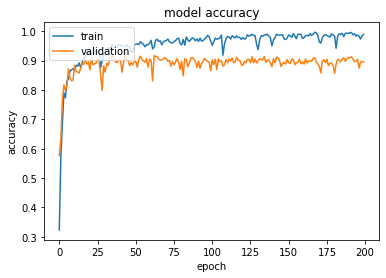

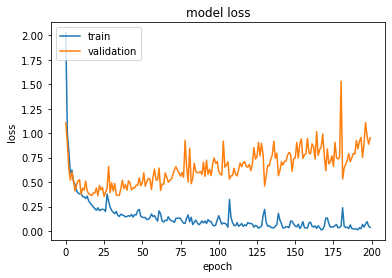

In [ ]:
Bacteria_multi_model_Adam_0001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adam_0001.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adam_0001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/200
106/106 [==============================] - 10s 90ms/step - loss: 3.7140 - accuracy: 0.2290 - val_loss: 1.4319 - val_accuracy: 0.4382
Epoch 2/200
106/106 [==============================] - 9s 88ms/step - loss: 1.5178 - accuracy: 0.3378 - val_loss: 1.2973 - val_accuracy: 0.4516
Epoch 3/200
106/106 [==============================] - 9s 88ms/step - loss: 1.3838 - accuracy: 0.3873 - val_loss: 1.2003 - val_accuracy: 0.4978
Epoch 4/200
106/106 [==============================] - 9s 88ms/step - loss: 1.2792 - accuracy: 0.4364 - val_loss: 1.0792 - val_accuracy: 0.6391
Epoch 5/200
106/106 [==============================] - 9s 88ms/step - loss: 1.1586 - accuracy: 0.4880 - val_loss: 0.9995 - val_accuracy: 0.6542
Epoch 6/200
106/106 [==============================] - 9s 88ms/step - loss: 1.1044 - accuracy: 0.5123 - val_loss: 0.9859 - val_accuracy: 0.5867
Epoch 7/200
106/106 [==============================] - 9s 88ms/step - loss: 1.0173 - accuracy: 0.5668 - val_loss: 0.9061 - val_accuracy

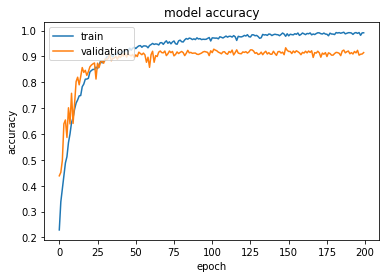

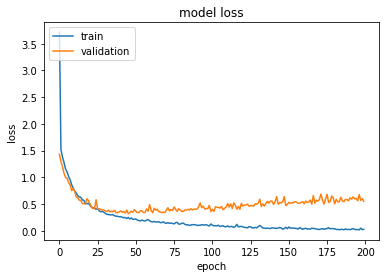

In [ ]:
Bacteria_multi_model_Adam_00001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adam_00001.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adam_00001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Adagrad_0.001_400epoch

Epoch 1/400
106/106 [==============================] - 1s 8ms/step - loss: 2.1114 - accuracy: 0.2596 - val_loss: 1.4447 - val_accuracy: 0.2916
Epoch 2/400
106/106 [==============================] - 1s 6ms/step - loss: 1.4805 - accuracy: 0.3292 - val_loss: 1.2845 - val_accuracy: 0.5040
Epoch 3/400
106/106 [==============================] - 1s 6ms/step - loss: 1.3706 - accuracy: 0.3938 - val_loss: 1.2522 - val_accuracy: 0.4738
Epoch 4/400
106/106 [==============================] - 1s 6ms/step - loss: 1.2946 - accuracy: 0.4424 - val_loss: 1.1413 - val_accuracy: 0.6009
Epoch 5/400
106/106 [==============================] - 1s 6ms/step - loss: 1.2313 - accuracy: 0.4637 - val_loss: 1.1001 - val_accuracy: 0.5902
Epoch 6/400
106/106 [==============================] - 1s 6ms/step - loss: 1.1743 - accuracy: 0.4868 - val_loss: 1.0364 - val_accuracy: 0.6427
Epoch 7/400
106/106 [==============================] - 1s 6ms/step - loss: 1.1358 - accuracy: 0.5194 - val_loss: 1.0236 - val_accuracy: 0.5876

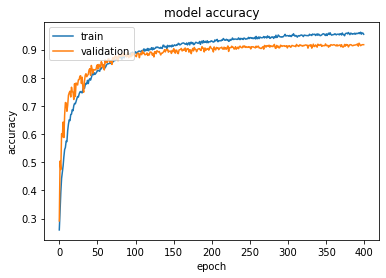

Maximum Train Accuracy : 0.9614814519882202
Maximum Validation Accuracy : 0.9226666688919067


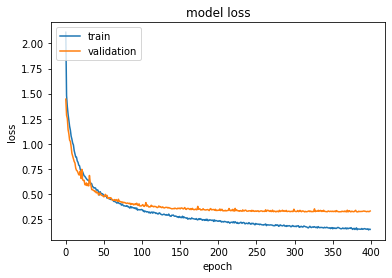

Minimum Train Loss : 0.14153426885604858
Minimum Validation Loss : 0.32062551379203796
[2.1113877296447754, 1.480523705482483, 1.3706434965133667, 1.2946183681488037, 1.2312889099121094, 1.1742743253707886, 1.1358046531677246, 1.0763558149337769, 1.046073079109192, 1.0070024728775024, 0.9879903793334961, 0.9317233562469482, 0.9021337628364563, 0.8686278462409973, 0.867017924785614, 0.8287572860717773, 0.8157069087028503, 0.7868061065673828, 0.7805010676383972, 0.7438437342643738, 0.7302142381668091, 0.7244170904159546, 0.7230168581008911, 0.7002627849578857, 0.6803664565086365, 0.6757432222366333, 0.6628889441490173, 0.6522351503372192, 0.6424538493156433, 0.636530876159668, 0.6368921399116516, 0.6192652583122253, 0.6139625310897827, 0.6066699624061584, 0.6010441184043884, 0.5736408233642578, 0.5690941214561462, 0.558667004108429, 0.5604323148727417, 0.5592595934867859, 0.5380639433860779, 0.5406193733215332, 0.5389232635498047, 0.5182547569274902, 0.48991215229034424, 0.52247959375381

In [ ]:
Bacteria_multi_model_Adagrad_0001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adagrad_0001.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adagrad_0001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=400,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(history.history['accuracy'])}")
print(f"Maximum Validation Accuracy : {max(history.history['val_accuracy'])}")


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(history.history['loss'])}")
print(f"Minimum Validation Loss : {min(history.history['val_loss'])}")

print(history.history['loss'])
print(history.history['val_loss'])

train_loss_mean = np.mean(history.history['loss'])
train_loss_std = np.std(history.history['loss'])

val_loss_mean = np.mean(history.history['val_loss'])
val_loss_std = np.std(history.history['val_loss'])

print(f"Train_Loss_mean: {train_loss_mean}")
print(f"Train_Loss_mean: {train_loss_std}")
print(f"Train_Loss_mean: {val_loss_mean}")
print(f"Train_Loss_mean: {val_loss_std}")

# Adagrad_0.001_400epoch_L2reg

In [ ]:
# from keras import relgularizers

conv = concatenate([amplitude_model, phase_model])
conv = Flatten()(conv)
dense = Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001))(conv)
dense = Dropout(0.5)(dense)
dense = Dense(256, activation='relu')(dense)
dense = Dropout(0.5)(dense)
output = Dense(num_classes, activation='softmax')(dense)

In [ ]:
Bacteria_multi_model_Adagrad_0001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adagrad_0001.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adagrad_0001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=400,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(history.history['accuracy'])}")
print(f"Maximum Validation Accuracy : {max(history.history['val_accuracy'])}")


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(history.history['loss'])}")
print(f"Minimum Validation Loss : {min(history.history['val_loss'])}")

# Adagrad_0.001_400epoch_batchnorm

In [ ]:
conv = concatenate([amplitude_model, phase_model])
conv = Flatten()(conv)
dense = Dense(512, activation='relu')(conv)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Dense(256, activation='relu')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
output = Dense(num_classes, activation='softmax')(dense)

In [ ]:
Bacteria_multi_model_Adagrad_0001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adagrad_0001.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adagrad_0001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=400,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(history.history['accuracy'])}")
print(f"Maximum Validation Accuracy : {max(history.history['val_accuracy'])}")


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(history.history['loss'])}")
print(f"Minimum Validation Loss : {min(history.history['val_loss'])}")

# Adam_0.0001_400epoch

In [ ]:
conv = concatenate([amplitude_model, phase_model])
conv = Flatten()(conv)
dense = Dense(512, activation='relu')(conv)
dense = Dropout(0.5)(dense)
dense = Dense(256, activation='relu')(dense)
dense = Dropout(0.5)(dense)
output = Dense(num_classes, activation='softmax')(dense)

Epoch 1/400
106/106 [==============================] - 1s 8ms/step - loss: 3.1414 - accuracy: 0.2566 - val_loss: 1.3743 - val_accuracy: 0.4533
Epoch 2/400
106/106 [==============================] - 1s 6ms/step - loss: 1.4630 - accuracy: 0.3440 - val_loss: 1.2414 - val_accuracy: 0.4649
Epoch 3/400
106/106 [==============================] - 1s 6ms/step - loss: 1.3276 - accuracy: 0.4116 - val_loss: 1.0993 - val_accuracy: 0.6133
Epoch 4/400
106/106 [==============================] - 1s 6ms/step - loss: 1.1949 - accuracy: 0.4661 - val_loss: 1.0239 - val_accuracy: 0.6524
Epoch 5/400
106/106 [==============================] - 1s 6ms/step - loss: 1.0762 - accuracy: 0.5407 - val_loss: 0.9240 - val_accuracy: 0.6604
Epoch 6/400
106/106 [==============================] - 1s 6ms/step - loss: 0.9904 - accuracy: 0.5733 - val_loss: 0.8357 - val_accuracy: 0.7547
Epoch 7/400
106/106 [==============================] - 1s 6ms/step - loss: 0.9103 - accuracy: 0.6187 - val_loss: 0.7844 - val_accuracy: 0.7236

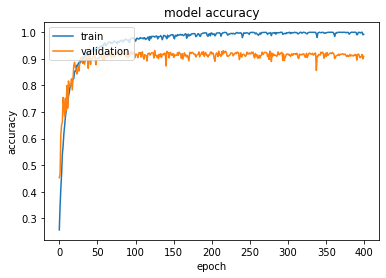

Maximum Train Accuracy : 1.0
Maximum Validation Accuracy : 0.9315555691719055


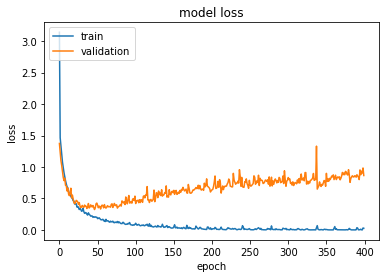

Minimum Train Loss : 0.0002681321057025343
Minimum Validation Loss : 0.32399529218673706


In [ ]:
Bacteria_multi_model_Adam_00001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adam_00001.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adam_00001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=400,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(history.history['accuracy'])}")
print(f"Maximum Validation Accuracy : {max(history.history['val_accuracy'])}")


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(history.history['loss'])}")
print(f"Minimum Validation Loss : {min(history.history['val_loss'])}")

p

# Adam_0.0001_400epoch_batchnorm

In [ ]:
conv = concatenate([amplitude_model, phase_model])
conv = Flatten()(conv)
dense = Dense(512, activation='relu')(conv)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Dense(256, activation='relu')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
output = Dense(num_classes, activation='softmax')(dense)

Epoch 1/400
106/106 [==============================] - 11s 94ms/step - loss: 1.9784 - accuracy: 0.3404 - val_loss: 11.3026 - val_accuracy: 0.1867
Epoch 2/400
106/106 [==============================] - 10s 92ms/step - loss: 1.5854 - accuracy: 0.4299 - val_loss: 3.0615 - val_accuracy: 0.2213
Epoch 3/400
106/106 [==============================] - 10s 93ms/step - loss: 1.3672 - accuracy: 0.4978 - val_loss: 3.6664 - val_accuracy: 0.1964
Epoch 4/400
106/106 [==============================] - 10s 92ms/step - loss: 1.2127 - accuracy: 0.5481 - val_loss: 2.1338 - val_accuracy: 0.3191
Epoch 5/400
106/106 [==============================] - 10s 95ms/step - loss: 1.0656 - accuracy: 0.5870 - val_loss: 1.4566 - val_accuracy: 0.4400
Epoch 6/400
106/106 [==============================] - 10s 93ms/step - loss: 0.9688 - accuracy: 0.6273 - val_loss: 2.0973 - val_accuracy: 0.4640
Epoch 7/400
106/106 [==============================] - 10s 93ms/step - loss: 0.9197 - accuracy: 0.6341 - val_loss: 1.5383 - val_a

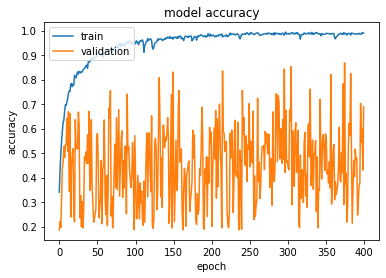

Maximum Train Accuracy : 0.993481457233429
Maximum Validation Accuracy : 0.8684444427490234


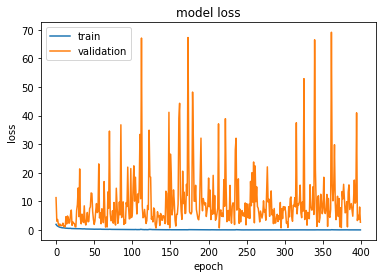

Minimum Train Loss : 0.020926935598254204
Minimum Validation Loss : 0.6782159805297852


In [ ]:
Bacteria_multi_model_Adam_00001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adam_00001.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adam_00001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=400,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(history.history['accuracy'])}")
print(f"Maximum Validation Accuracy : {max(history.history['val_accuracy'])}")


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(history.history['loss'])}")
print(f"Minimum Validation Loss : {min(history.history['val_loss'])}")

# Adam_0.0001_400epoch__L2

In [ ]:
# from keras import relgularizers

conv = concatenate([amplitude_model, phase_model])
conv = Flatten()(conv)
dense = Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01))(conv)
dense = Dropout(0.5)(dense)
dense = Dense(256, activation='relu')(dense)
dense = Dropout(0.5)(dense)
output = Dense(num_classes, activation='softmax')(dense)

Epoch 1/400
106/106 [==============================] - 2s 8ms/step - loss: 8.8833 - accuracy: 0.2394 - val_loss: 6.6676 - val_accuracy: 0.4569
Epoch 2/400
106/106 [==============================] - 1s 6ms/step - loss: 6.2213 - accuracy: 0.3253 - val_loss: 5.5283 - val_accuracy: 0.5129
Epoch 3/400
106/106 [==============================] - 1s 6ms/step - loss: 5.2502 - accuracy: 0.4273 - val_loss: 4.7447 - val_accuracy: 0.5164
Epoch 4/400
106/106 [==============================] - 1s 6ms/step - loss: 4.5415 - accuracy: 0.5073 - val_loss: 4.2230 - val_accuracy: 0.6133
Epoch 5/400
106/106 [==============================] - 1s 6ms/step - loss: 4.0864 - accuracy: 0.5692 - val_loss: 3.7441 - val_accuracy: 0.7040
Epoch 6/400
106/106 [==============================] - 1s 6ms/step - loss: 3.6885 - accuracy: 0.6403 - val_loss: 3.4062 - val_accuracy: 0.7458
Epoch 7/400
106/106 [==============================] - 1s 6ms/step - loss: 3.3798 - accuracy: 0.6865 - val_loss: 3.2342 - val_accuracy: 0.6996

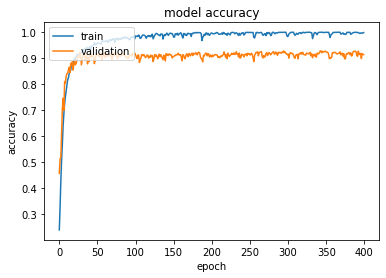

Maximum Train Accuracy : 1.0
Maximum Validation Accuracy : 0.9279999732971191


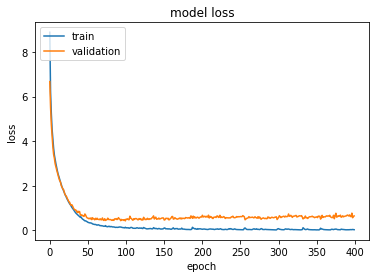

Minimum Train Loss : 0.016157446429133415
Minimum Validation Loss : 0.422050416469574
[8.883282661437988, 6.2212958335876465, 5.250163555145264, 4.541517734527588, 4.086363315582275, 3.688469409942627, 3.3798141479492188, 3.1749420166015625, 2.9860751628875732, 2.8112637996673584, 2.657555341720581, 2.510002374649048, 2.402275800704956, 2.275742292404175, 2.162795066833496, 2.063533067703247, 1.9445829391479492, 1.8622496128082275, 1.7860158681869507, 1.6927553415298462, 1.599194049835205, 1.539389729499817, 1.4526238441467285, 1.3837321996688843, 1.3099292516708374, 1.2497496604919434, 1.1904739141464233, 1.1442060470581055, 1.0843437910079956, 1.0244742631912231, 0.9803869128227234, 0.931363046169281, 0.8755949139595032, 0.8265483975410461, 0.7782515287399292, 0.7449883818626404, 0.7116689085960388, 0.6847673654556274, 0.6444891691207886, 0.6222156286239624, 0.5776747465133667, 0.5959325432777405, 0.5368557572364807, 0.49964895844459534, 0.48124414682388306, 0.4485781192779541, 0.422

In [ ]:
Bacteria_multi_model_Adam_00001 = tf.keras.models.clone_model(Model(inputs=[amplitude_input, phase_input], outputs=[output]))
Bacteria_multi_model_Adam_00001.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics = ['accuracy'])

# best_weights_file = r'/content/drive/MyDrive/21-2/thesis/211020_dataset/best_weights.hdf5'
# checkpoint_dir = os.path.dirname(best_weights_file)

# cp_callback = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = Bacteria_multi_model_Adam_00001.fit([x_train_amplitude, x_train_phase], y_train,
                    batch_size=batch_size,
                    epochs=400,
                    # callbacks=[cp_callback],
                    verbose=1,
                    validation_data=([x_test_amplitude, x_test_phase], y_test),
                    shuffle=True)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(history.history['accuracy'])}")
print(f"Maximum Validation Accuracy : {max(history.history['val_accuracy'])}")


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(history.history['loss'])}")
print(f"Minimum Validation Loss : {min(history.history['val_loss'])}")

print(history.history['loss'])
print(history.history['val_loss'])

train_loss_mean = np.mean(history.history['loss'])
train_loss_std = np.std(history.history['loss'])

val_loss_mean = np.mean(history.history['val_loss'])
val_loss_std = np.std(history.history['val_loss'])

print(f"Train_Loss_mean: {train_loss_mean}")
print(f"Train_Loss_mean: {train_loss_std}")
print(f"Train_Loss_mean: {val_loss_mean}")
print(f"Train_Loss_mean: {val_loss_std}")

# model save & test & confusion matrix

In [ ]:
# model.save_weights(r'G:\Spyder_Project\FPM_CNN\1005_dataset_new\weights_1005.hdf5')
# model.save(r'G:\Spyder_Project\FPM_CNN\1005_dataset_new\Model_dual_1008.h5')
Bacteria_multi_model_Adagrad_0001.save(r'/content/drive/MyDrive/21-2/thesis/multiadagrad.h5')
Bacteria_multi_model_Adam_00001.save(r'/content/drive/MyDrive/21-2/thesis/multiadam.h5')

In [ ]:
# load model
Adagrad_0001 = tf.keras.models.load_model(r'/content/drive/MyDrive/21-2/thesis/multiadagrad.h5')
final_loss, final_acc = Adagrad_0001.evaluate([x_test_amplitude, x_test_phase], y_test, verbose=2)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))  

36/36 - 0s - loss: 0.3293 - accuracy: 0.9138 - 252ms/epoch - 7ms/step
Final loss: 0.329273, final accuracy: 0.913778


In [ ]:
# load model
Adam_00001 = tf.keras.models.load_model(r'/content/drive/MyDrive/21-2/thesis/multiadam.h5')
final_loss, final_acc = Adam_00001.evaluate([x_test_amplitude, x_test_phase], y_test, verbose=2)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))  

36/36 - 0s - loss: 0.7239 - accuracy: 0.8924 - 264ms/epoch - 7ms/step
Final loss: 0.723931, final accuracy: 0.892444


In [ ]:
test_df = pd.read_csv(r'/content/drive/MyDrive/21-2/thesis/211020_dataset/test_labels.csv', index_col=0)
test_df['amplitude_file'] = test_df.index.map(lambda id : f'/content/drive/MyDrive/21-2/thesis/211020_dataset/test/{id}_a.jpg')
test_df['phase_file'] = test_df.index.map(lambda id : f'/content/drive/MyDrive/21-2/thesis/211020_dataset/test/{id}_p.jpg')

Adagrad_0001 = tf.keras.models.load_model(r'/content/drive/MyDrive/21-2/thesis/multiadagrad.h5')


# test_df = pd.read_csv(r'G:\Spyder_Project\FPM_CNN\1005_dataset_new\test_labels_0915.csv', index_col=0)

# test_df['amplitude_file'] = test_df.index.map(lambda id: f'1005_dataset_new/validation_2nd/{id}_a.jpg')
# test_df['phase_file'] = test_df.index.map(lambda id: f'1005_dataset_new/validation_2nd/{id}_p.jpg')

print(test_df.head())

x_test_amplitude = read_images(test_df.amplitude_file.values, img_rows, img_cols, as_gray, in_channel)
x_test_phase = read_images(test_df.phase_file.values, img_rows, img_cols, as_gray, in_channel)

        bacteria  ...                                         phase_file
id                ...                                                   
904500         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...
904501         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...
904502         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...
904503         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...
904504         0  ...  /content/drive/MyDrive/21-2/thesis/211020_data...

[5 rows x 3 columns]


In [ ]:
#get the predictions for the test data
predicted_classes = Adagrad_0001.predict([x_test_amplitude, x_test_phase])
# predict_df.bacteria = np.argmax(predicted_classes,axis=1)

predict_df = np.argmax(predicted_classes,axis=1)
test_df = test_df.drop(['amplitude_file', 'phase_file'], axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_df, predict_df))
print('Classification Report')

Confusion Matrix
[[100   0   0   0   0]
 [  0  86   7   0   7]
 [  0   6  93   0   1]
 [  3   5   0  85   7]
 [  1   4   1   2  92]]
Classification Report


In [ ]:
predict_df


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 1,
       1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 2, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       0.85      0.86      0.86       100
           2       0.92      0.93      0.93       100
           3       0.98      0.85      0.91       100
           4       0.86      0.92      0.89       100

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



Text(0.5, 1.0, 'BC           BR           MI           SA           SE')

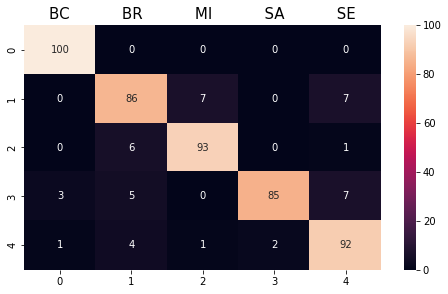

In [ ]:
report = classification_report(test_df, predict_df)
print(report)

plt.figure(figsize=(16/2,9/2))
y_pred_labels = [ np.argmax(label) for label in predict_df]
cm = confusion_matrix(test_df, predict_df)

# show cm 

# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('BC           BR           MI           SA           SE', fontsize=15)